Importamos las dependencias

In [11]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt

Cargamos desde el repositorio de github los datos

In [12]:
url = 'https://github.com/Alf-caput/P1_MineriaDeDatos/raw/main/P3_ReduccionDimensionalidad/USA.xlsx'
df = pd.read_excel(url)
df.head()

,Ciudad,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
0,Phoenix,10.0,70.3,213.0,582.0,6.0,7.05,36.0
1,Little Rock,13.0,61.0,91.0,132.0,8.2,48.52,100.0
2,San Francisco,12.0,56.7,453.0,716.0,8.7,20.66,67.0
3,Denver,17.0,51.9,454.0,515.0,9.0,12.95,86.0
4,Hartford,56.0,49.1,412.0,158.0,9.0,43.37,127.0


Se trata de un set de datos sobre ciudades, las variables del mismo son:

In [13]:
df.columns

Index(['Ciudad', 'SO2', 'Neg.Temp', 'Empresas', 'Poblacion', 'Viento',
       'Precip', 'Dias'],
      dtype='object')

No contamos con documentación, pero parece que tiene que ver con mediciones del ambiente y demografía en ciudades.\
Podemos tratar de interpretar que pueden significar:
- Ciudad, nombre de ciudad
- SO2, concentración dióxido de azufre en el aire
- Neg.Temp, temperatura Fahrenheit
- Empresas, número de empresas
- Poblacion, dato relacionado con la población de la ciudad (no puede ser el número de habitantes)
- Viento, velocidad del viento
- Precip, precipitaciones
- Dias, número de días

Comprobamos la existencia de valores NA o nulos

In [14]:
count_df = pd.DataFrame({
    'Valores NA': df.isna().sum(),
    'Valores NULL': df.isnull().sum(),
})
count_df

,Valores NA,Valores NULL
Ciudad,0,0
SO2,0,0
Neg.Temp,0,0
Empresas,0,0
Poblacion,0,0
Viento,0,0
Precip,0,0
Dias,0,0


Comprobamos el tipo de dato de cada columna

In [15]:
df.dtypes

Ciudad        object
SO2          float64
Neg.Temp     float64
Empresas     float64
Poblacion    float64
Viento       float64
Precip       float64
Dias         float64
dtype: object

Nos fijamos que son float64 excepto los valores que toma la variable ciudad que son strings (pandas por defecto considera strings como tipo obj)\
A simple vista parece que las ciudades del dataset son únicas, lo podemos comprobar:

In [16]:
df.loc[:, 'Ciudad'].nunique() == len(df.loc[:, 'Ciudad'])

True

Utilizaremos el nombre de la ciudad como índice de fila (es conveniente para estandarizar el resto de variables)

In [17]:
df = df.set_index('Ciudad')
df.head()

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
Ciudad,,,,,,,
Phoenix,10.0,70.3,213.0,582.0,6.0,7.05,36.0
Little Rock,13.0,61.0,91.0,132.0,8.2,48.52,100.0
San Francisco,12.0,56.7,453.0,716.0,8.7,20.66,67.0
Denver,17.0,51.9,454.0,515.0,9.0,12.95,86.0
Hartford,56.0,49.1,412.0,158.0,9.0,43.37,127.0


Estandarizamos el dataframe, para pasar todas las variables al mismo rango

In [18]:
from sklearn.preprocessing import StandardScaler

# Inicializar el StandardScaler
scaler = StandardScaler()

# Ajustar el scaler al conjunto de datos y transformar los datos
df_std = scaler.fit_transform(df)

# Convertir los datos estandarizados de nuevo a un DataFrame
df_std = pd.DataFrame(df_std, columns=df.columns, index=df.index)

# Imprimir el DataFrame estandarizado
df_std.head()

,SO2,Neg.Temp,Empresas,Poblacion,Viento,Precip,Dias
Ciudad,,,,,,,
Phoenix,-0.864758,2.036213,-0.449363,-0.046520,-2.440555,-2.556012,-2.975514
Little Rock,-0.735360,0.733515,-0.668567,-0.833224,-0.881504,1.010653,-0.531009
San Francisco,-0.778493,0.131192,-0.018143,0.187743,-0.527174,-1.385471,-1.791457
Denver,-0.562829,-0.541168,-0.016346,-0.163651,-0.314576,-2.048577,-1.065744
Hartford,1.119347,-0.933378,-0.091810,-0.787770,-0.314576,0.567723,0.500266


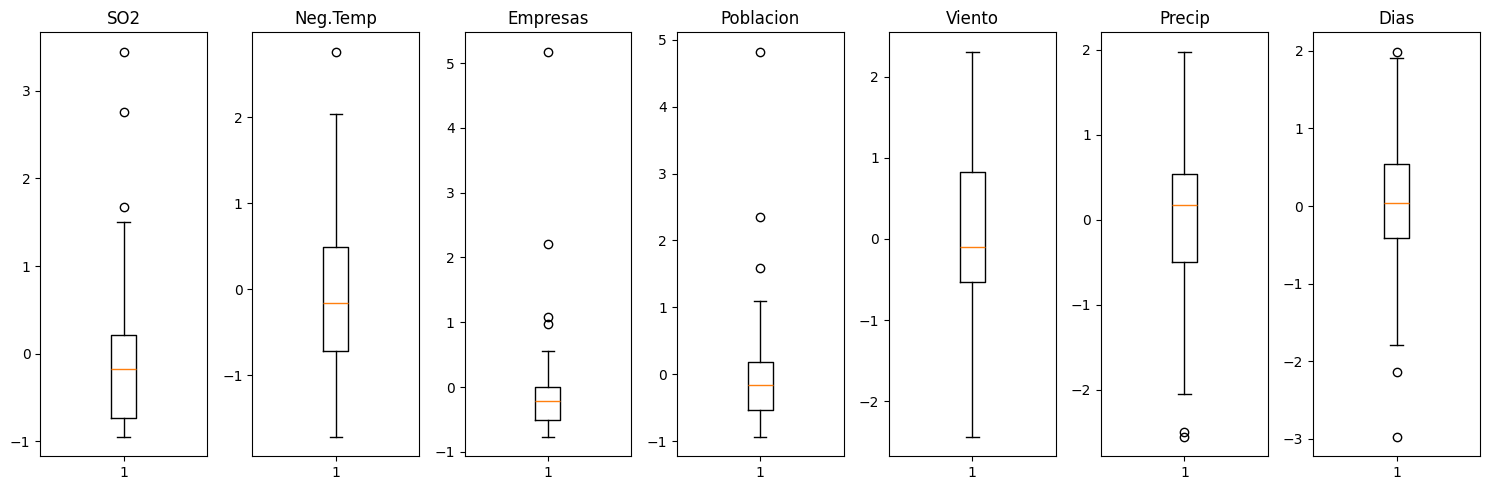

In [19]:
# Crear subplots
fig, axs = plt.subplots(nrows=1, ncols=len(df_std.columns), figsize=(15, 5))

# Iterar sobre cada columna y crear un boxplot
for i, columna in enumerate(df_std.columns):
    axs[i].boxplot(df_std[columna])
    axs[i].set_title(columna)

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()
